--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (1000, 2)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

--- Training DistilBERT Model ---


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.000200
40,3.004300
60,2.997900
80,3.014500
100,3.009200
120,3.016400
140,2.996100
160,3.001000
180,3.002300
200,2.990100



--- Generating TF-IDF Features ---

--- Training Logistic Regression on TF-IDF Features ---


--- Evaluating Hybrid (DistilBERT + TF-IDF) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.17      0.08      0.11        13
      blockchain       0.29      0.38      0.33        13
          career       0.33      0.29      0.31        14
          climat       0.67      0.31      0.42        13
      cybersecur       0.33      0.43      0.38        14
            data       0.33      0.38      0.36        13
           digit       0.46      0.43      0.44        14
            educ       0.47      0.64      0.55        14
entrepreneurship       0.38      0.62      0.47        13
     environment       0.86      0.43      0.57        14
          health       0.67      0.43      0.52        14
         histori       0.22      0.15      0.18        13
          machin       0.36      0.36      0.36        14
          person       0.00      0.00      0.00        14
       psycholog       0.55      0.43      0.48        14
         quantum       0.46      

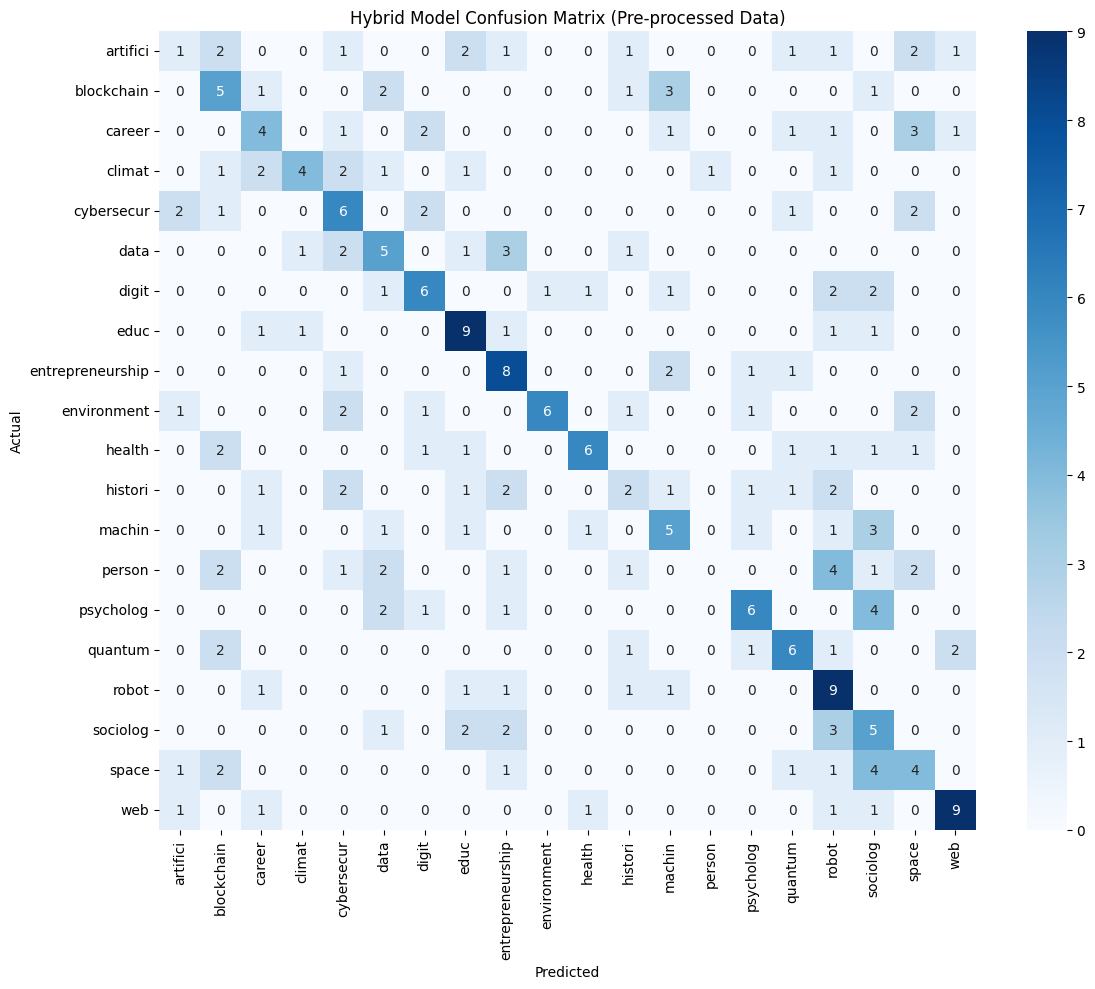

In [1]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_Jumbo.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels and Handle Class Imbalance
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 5: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)
train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()
train_labels = train_df['label'].values
val_labels = val_df['label'].values

# --- PART 1: Train the DistilBERT Supervised Classifier ---

# Step 6: Prepare DistilBERT Datasets
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

class ClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

train_encodings_db = tokenize(train_texts, distilbert_tokenizer)
val_encodings_db = tokenize(val_texts, distilbert_tokenizer)
train_dataset_db = ClassificationDataset(train_encodings_db, train_labels)
val_dataset_db = ClassificationDataset(val_encodings_db, val_labels)

# Step 7: Train DistilBERT
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./hybrid/distilbert', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- PART 2: Train the TF-IDF + Logistic Regression Classifier ---

# Step 8: Create TF-IDF Features from Text
print("\n--- Generating TF-IDF Features ---")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)

# Step 9: Train Logistic Regression on TF-IDF Features
print("\n--- Training Logistic Regression on TF-IDF Features ---")
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_tfidf, train_labels)

# --- PART 3: Ensemble Predictions and Evaluate ---
print("\n" + "="*50 + "\n")
print("--- Evaluating Hybrid (DistilBERT + TF-IDF) Model ---")

# Step 10: Get Probabilities from Both Paths
# Path 1: DistilBERT
preds_db = trainer_db.predict(val_dataset_db)
probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()

# Path 2: TF-IDF + Logistic Regression
probs_tfidf = logreg.predict_proba(X_val_tfidf)

# Step 11: Average the probabilities
avg_probs = (probs_db + probs_tfidf) / 2
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_labels

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_distilbert_tfidf.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_distilbert_tfidf.png")

**Top2vec + AlBERT**

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (1000, 2)


--- Training ALBERT Model ---


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.064400
40,3.024200
60,3.018600
80,3.052800
100,3.021100
120,3.054400
140,2.999300
160,3.014300
180,3.037000
200,3.022100



--- Generating TF-IDF Features ---

--- Training Logistic Regression on TF-IDF Features ---


--- Evaluating Hybrid (ALBERT + TF-IDF) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00        13
      blockchain       0.26      0.46      0.33        13
          career       0.24      0.43      0.31        14
          climat       0.07      0.08      0.07        13
      cybersecur       0.50      0.50      0.50        14
            data       0.89      0.62      0.73        13
           digit       0.88      0.50      0.64        14
            educ       0.55      0.43      0.48        14
entrepreneurship       0.60      0.69      0.64        13
     environment       0.62      0.57      0.59        14
          health       0.86      0.43      0.57        14
         histori       0.43      0.46      0.44        13
          machin       0.50      0.29      0.36        14
          person       0.00      0.00      0.00        14
       psycholog       0.40      0.57      0.47        14
         quantum       0.55      

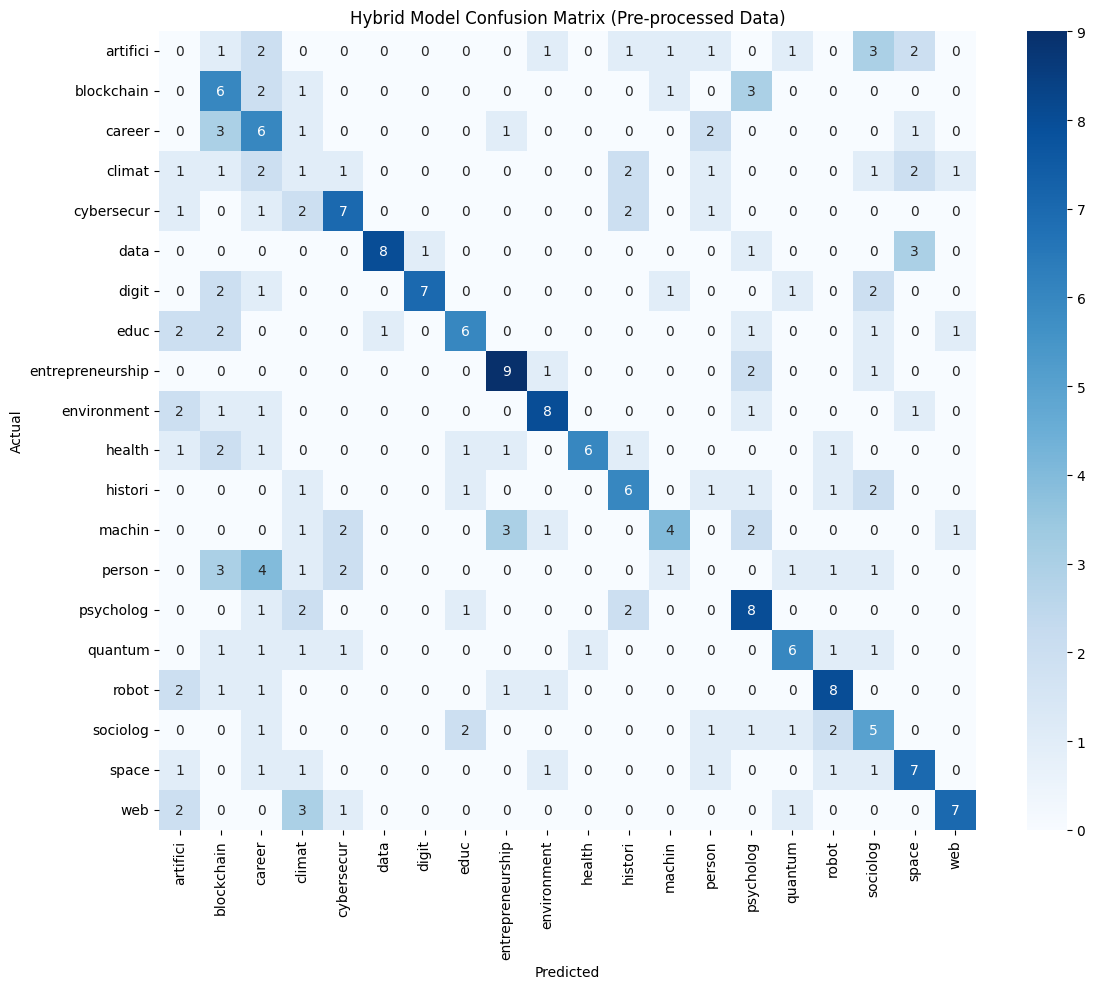

In [10]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_Jumbo.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels and Handle Class Imbalance
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 5: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)
train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()
train_labels = train_df['label'].values
val_labels = val_df['label'].values


# --- PART 1: Train the ALBERT Supervised Classifier ---

# Step 6: Prepare ALBERT Datasets
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

class ClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

train_encodings_albert = tokenize(train_texts, albert_tokenizer)
val_encodings_albert = tokenize(val_texts, albert_tokenizer)
train_dataset_albert = ClassificationDataset(train_encodings_albert, train_labels)
val_dataset_albert = ClassificationDataset(val_encodings_albert, val_labels)

# Step 7: Train ALBERT
print("--- Training ALBERT Model ---")
model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_labels)
training_args_albert = TrainingArguments(
    output_dir='./hybrid/albert', num_train_epochs=15, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_albert = Trainer(model=model_albert, args=training_args_albert, train_dataset=train_dataset_albert)
trainer_albert.train()


# --- PART 2: Train the TF-IDF + Logistic Regression Classifier ---

# Step 8: Create TF-IDF Features from Text
print("\n--- Generating TF-IDF Features ---")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)

# Step 9: Train Logistic Regression on TF-IDF Features
print("\n--- Training Logistic Regression on TF-IDF Features ---")
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_tfidf, train_labels)


# --- PART 3: Ensemble Predictions and Evaluate ---
print("\n" + "="*50 + "\n")
print("--- Evaluating Hybrid (ALBERT + TF-IDF) Model ---")

# Step 10: Get Probabilities from Both Paths
# Path 1: ALBERT
preds_albert = trainer_albert.predict(val_dataset_albert)
probs_albert = torch.softmax(torch.from_numpy(preds_albert.predictions), dim=1).numpy()

# Path 2: TF-IDF + Logistic Regression
probs_tfidf = logreg.predict_proba(X_val_tfidf)

# Step 11: Average the probabilities (giving more weight to the transformer model)
avg_probs = (0.6 * probs_albert) + (0.4 * probs_tfidf)
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_labels

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_albert_tfidf.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_albert_tfidf.png")

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (1000, 2)


--- Training ALBERT Model ---


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.065300
40,3.032200
60,3.024100
80,3.058500
100,3.003800
120,3.038000
140,2.975600
160,2.996500
180,3.058200
200,3.017400



--- Generating TF-IDF Features ---

--- Training Logistic Regression on TF-IDF Features ---


--- Evaluating Hybrid (ALBERT + TF-IDF) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.21      0.23      0.22        13
      blockchain       0.33      0.38      0.36        13
          career       0.47      0.50      0.48        14
          climat       0.42      0.38      0.40        13
      cybersecur       0.47      0.64      0.55        14
            data       0.58      0.54      0.56        13
           digit       0.50      0.50      0.50        14
            educ       0.67      0.57      0.62        14
entrepreneurship       0.47      0.62      0.53        13
     environment       0.28      0.36      0.31        14
          health       0.33      0.50      0.40        14
         histori       0.18      0.31      0.23        13
          machin       0.71      0.36      0.48        14
          person       0.29      0.14      0.19        14
       psycholog       0.83      0.36      0.50        14
         quantum       0.50      

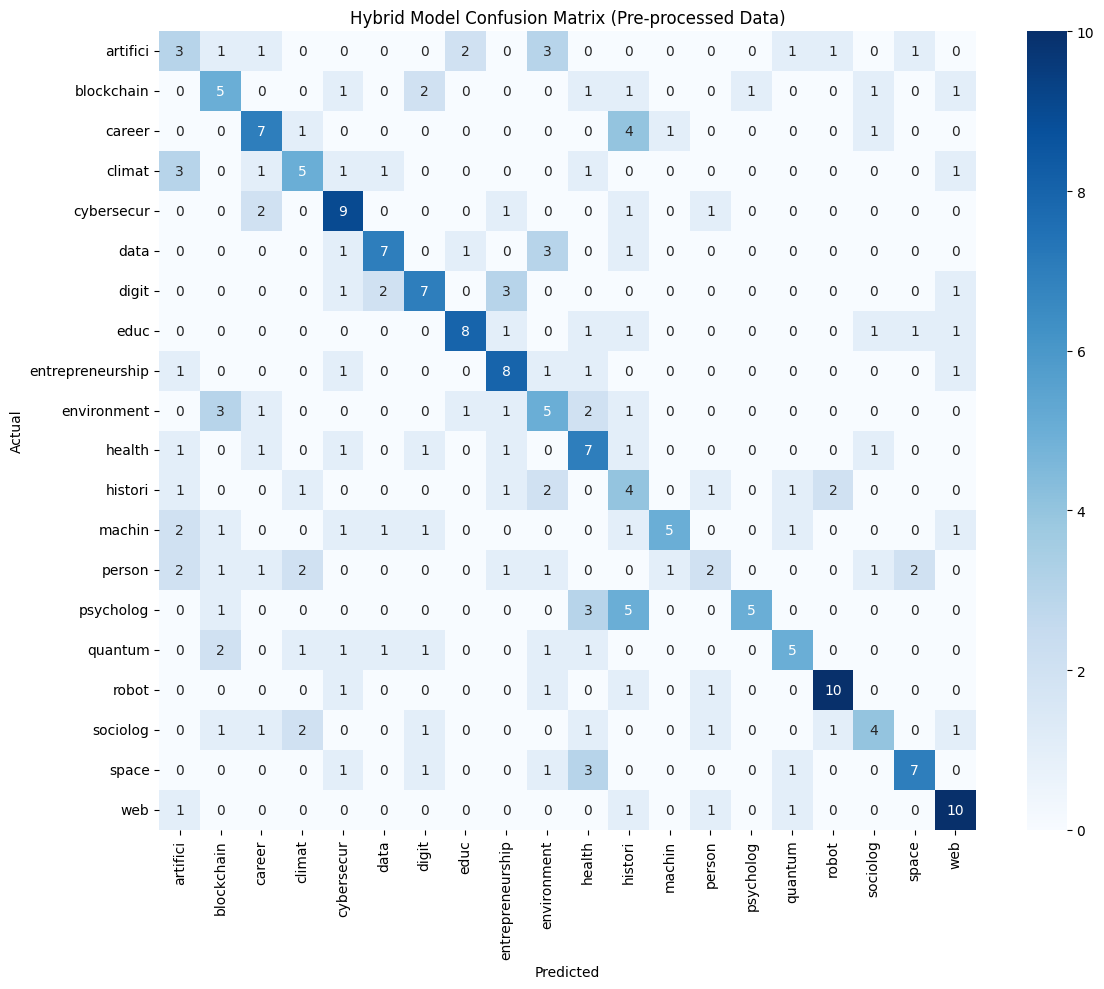

In [14]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_Jumbo.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels and Handle Class Imbalance
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 5: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)
train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()
train_labels = train_df['label'].values
val_labels = val_df['label'].values


# --- PART 1: Train the ALBERT Supervised Classifier ---

# Step 6: Prepare ALBERT Datasets
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

class ClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

train_encodings_albert = tokenize(train_texts, albert_tokenizer)
val_encodings_albert = tokenize(val_texts, albert_tokenizer)
train_dataset_albert = ClassificationDataset(train_encodings_albert, train_labels)
val_dataset_albert = ClassificationDataset(val_encodings_albert, val_labels)

# Step 7: Train ALBERT
print("--- Training ALBERT Model ---")
model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_labels)
training_args_albert = TrainingArguments(
    output_dir='./hybrid/albert', num_train_epochs=18, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_albert = Trainer(model=model_albert, args=training_args_albert, train_dataset=train_dataset_albert)
trainer_albert.train()


# --- PART 2: Train the TF-IDF + Logistic Regression Classifier ---

# Step 8: Create TF-IDF Features from Text
print("\n--- Generating TF-IDF Features ---")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)

# Step 9: Train Logistic Regression on TF-IDF Features
print("\n--- Training Logistic Regression on TF-IDF Features ---")
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_tfidf, train_labels)


# --- PART 3: Ensemble Predictions and Evaluate ---
print("\n" + "="*50 + "\n")
print("--- Evaluating Hybrid (ALBERT + TF-IDF) Model ---")

# Step 10: Get Probabilities from Both Paths
# Path 1: ALBERT
preds_albert = trainer_albert.predict(val_dataset_albert)
probs_albert = torch.softmax(torch.from_numpy(preds_albert.predictions), dim=1).numpy()

# Path 2: TF-IDF + Logistic Regression
probs_tfidf = logreg.predict_proba(X_val_tfidf)

# Step 11: Average the probabilities (giving more weight to the transformer model)
avg_probs = (0.6 * probs_albert) + (0.4 * probs_tfidf)
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_labels

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_albert_tfidf.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_albert_tfidf.png")


# --- Step 12: Inference with Hybrid Model (Testing on new input text) ---
print("\n" + "="*50 + "\n")
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

# --- Path 1: Get ALBERT prediction ---
inputs_albert = tokenize([test_text], albert_tokenizer)
device = trainer_albert.args.device
inputs_albert = {k: v.to(device) for k, v in inputs_albert.items()}

model_albert.eval()
with torch.no_grad():
    logits_albert = model_albert(**inputs_albert).logits
    probs_albert_inf = torch.softmax(logits_albert, dim=1).cpu().numpy()

# --- Path 2: Get TF-IDF + Logistic Regression prediction ---
X_test_tfidf = tfidf_vectorizer.transform([test_text])
probs_tfidf_inf = logreg.predict_proba(X_test_tfidf)

# --- Ensemble the predictions ---
avg_probs_inf = (0.6 * probs_albert_inf) + (0.4 * probs_tfidf_inf)

# Get the final prediction
pred_label_index = np.argmax(avg_probs_inf, axis=1)[0]
pred_topic = label_encoder.inverse_transform([pred_label_index])[0]

print(f"Input Text: \"{test_text}\"")
print(f"Predicted topic: {pred_topic}")